## Step 0: Required Packages

In [ ]:
#@title Install PyGithub
!pip install PyGithub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 77.5 MB/s eta 0:00:00


In [ ]:
# Data tool
import pandas as pd
import numpy as np
import re  #for regular expression
from datetime import datetime, timedelta # for Time
# Github
from github import Github
pd.options.mode.chained_assignment = None  # default='warn'

def get_pddf_Full():
    # No Input Argument
    # github token
    GITHUB_TOKEN = "get your own token"
    
    g = Github(GITHUB_TOKEN)
    repo = g.get_repo('support-team/customer-feedback') # fake repo

    # get all issue
    # time = datetime.utcnow() - timedelta(hours = 1)
    project_Full = repo.get_issues(state = 'all')

    Full = []
    for issue in project_Full:
        assignees = []
        assignee_username = []
        for assignee in issue.assignees:
            assignees.append(assignee.login)
            # assignee.name may be None
            if assignee.name == None:
              assignee_username.append(assignee.login)
            else:
              assignee_username.append(assignee.name)
        labels = []
        for label in issue.labels:
            labels.append(label.name)
        Full.append([
            issue.number,
            issue.html_url,
            issue.title,
            issue.state,
            issue.body,
            ', '.join(assignees),
            ', '.join(assignee_username),
            pd.to_datetime(issue.created_at),
            pd.to_datetime(issue.updated_at),
            None if issue.closed_at is None else pd.to_datetime(issue.closed_at),
            ','.join(labels),
        ])

    pddf_Full = pd.DataFrame(Full,columns=[
                  'Issue_ID', 'URL', 'Title', 'State',
                  'Description', 'Assignee',
                  'Assignee_Username', 'Created_At_UTC',
                  'Updated_At_UTC', 'Closed_At_UTC', 'Labels'
                  ])

    return pddf_Full

In [ ]:
test_data = get_pddf_Full()

Following Github server redirection from /repos/jy-support-team/customer-feedback to /repositories/579095430
INFO:github.Requester:Following Github server redirection from /repos/jy-support-team/customer-feedback to /repositories/579095430
<ipython-input-2-dbdf967e2c95>:67: FutureWarning: The default value of regex will change from True to False in a future version.
  pddf_Full["Dimension"] = pddf_Full["Labels"].str.replace(r"(/_|_)","/")
<ipython-input-2-dbdf967e2c95>:69: FutureWarning: The default value of regex will change from True to False in a future version.
  pddf_Full["Dimension"] = pddf_Full["Dimension"].str.replace(r"(,.+)","")
<ipython-input-2-dbdf967e2c95>:103: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pddf_Full_wish_origin["Responsible"] = pddf_Full_wish_origin["Email"].str.contains(r"(^(\w|\.|\_|\-)+[@](\w|\_|\-|\.)+[.]\w{2,3}$)")
<ipython-input-2-dbdf967e2c95>:148: UserWarning: 

## Step 1：Data Preprocessing，you can skip this part。（different from Step 2）

In [ ]:
#@title Extracting Problem Description / Problem Reproduction Method from Bug Reports
pd.options.mode.chained_assignment = None  # default='warn'

pddf_Full_proposed_question = pddf_Full_origin.copy()
pddf_Full_proposed_question["Description"] = pddf_Full_proposed_question["Description"].str.replace("<br>\n", ", ")
pddf_Full_proposed_question_after = pddf_Full_proposed_question.loc[pddf_Full["Description"].str.startswith((", 【Bug Report】"))]

pddf_Full_proposed_question_after['Title'] = pddf_Full_proposed_question['Title']
pddf_Full_proposed_question_after['Problem_Description/Request'] = pddf_Full_proposed_question_after["Description"].str.extract(r"((?<=Problem description, ).+(?=, , ▌Reproduction method))")
pddf_Full_proposed_question_after['Reproduction_Method'] = pddf_Full_proposed_question_after["Description"].str.extract(r"((?<=Reproduction method, ).+(?=, , ▌Device where the problem occurs))")
pddf_Full_proposed_question_after['Labels'] = pddf_Full_proposed_question['Labels']

question = pddf_Full_proposed_question_after[['Title', 'Problem_Description/Request', 'Reproduction_Method', 'Labels']]
question

In [ ]:
#@title Extracting Requirements Description / Operation Method for Platform Feature Wishes
pd.options.mode.chained_assignment = None  # default='warn'

pddf_Full_wish = pddf_Full_origin.copy()
pddf_Full_wish["Description"] = pddf_Full_wish["Description"].str.replace("<br>\n", ", ")
pddf_Full_wish_after = pddf_Full_wish.loc[pddf_Full["Description"].str.startswith((", 【Platform Feature Wish】"))]

pddf_Full_wish_after['Title'] = pddf_Full_wish['Title']
pddf_Full_wish_after['Requirement_Description/Request'] = pddf_Full_wish_after["Description"].str.extract(r"((?<=Requirement description, ).+(?=, , ▌Operation method))")
pddf_Full_wish_after['Operation_Method'] = pddf_Full_wish_after["Description"].str.extract(r"((?<=Operation method, ).+(?=, , , ==================, 【More Information】))")
pddf_Full_wish_after['Labels'] = pddf_Full_wish['Labels']

wish = pddf_Full_wish_after[['Title', 'Requirement_Description/Request', 'Operation_Method', 'Labels']]
wish

In [ ]:
#@title Merge Bug Reports and Wishes
all_issue = pd.concat([question, wish]).sort_index(axis=0)
all_issue

# Select Bug Reports from Customer Support Team
issues = all_issue.loc[all_issue['Labels'].str.contains('Team::Customer Support')]
issues

# Select Undetermined Reports
trash_issues = all_issue.loc[all_issue['Labels'].str.contains('Customer Support/Other::Unable to Determine')]
trash_issues

# export csv file
from google.colab import files
trash_issues.to_csv('trash_issue.csv', encoding = 'utf-8-sig')
files.download('trash_issue.csv')

# Check the number of issues with misconceptions
nowrong_issues = all_issue.loc[all_issue['Labels'].str.contains('Customer Support/Problem with Questions::Misconception')]
nowrong_issues

# Total of 4248 customer support emails, with 593 classified as trash issues, accounting for 13.96%.
# There are a total of 4248 customer service emails, of which 1071 are related to misconceptions, accounting for 25.21%.
# Therefore, the total number of emails related to spam and misconceptions is 1664, accounting for 39.17%.


# Step 2：NLP to deal with issues

In [ ]:
#@title install jieba & nltk
!pip install jieba
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title connect google drive
# cloud link：https://drive.google.com/file/d/1J_UhfMNrQkk0y0UY6vyRoPqUH7My9U42/view?usp=share_link
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Categorize spam and non-spam emails, and add labels.
pd.options.mode.chained_assignment = None  # default='warn'
mail = pddf_Full_origin.copy()

# Only need to extract Issue_id, Proposed_Question_all, and labels, and add the label spam/ham based on whether labels contain "Unable to determine"
mail['Description'] = mail['Description'].str.replace("<br>\n",", ")
mail_question = mail.loc[pddf_Full["Description"].str.startswith((", 【Problem Report】"))]
mail_wish = mail.loc[pddf_Full["Description"].str.startswith((", 【Platform Feature Wish】"))]

# Problem report
mail_question['proposed_question/request'] = mail_question["Description"].str.extract(r"((?<=Problem description, ).+(?=, , ▌Reproducibility of the problem))")
mail_question['content_old'] = mail_question["Description"].str.extract(r"((?<=Reproducibility of the problem, ).+(?=, , ▌Device where the problem occurred))")
mail_question = mail_question.replace("No content provided",' ')
mail_question['content'] = mail_question['proposed_question/request'] + ', ' + mail_question['content_old']

mail_question['Labels'] = mail['Labels']
mail_question = mail_question[['Issue_ID', 'Labels', 'content']]

# Platform feature wish
mail["Description"] = mail["Description"].str.replace("<br>\n",", ")
mail_wish = mail.loc[pddf_Full["Description"].str.startswith((", 【Platform Feature Wish】"))]

mail_wish['proposed_question/request'] = mail_wish["Description"].str.extract(r"((?<=Requirement description, ).+(?=, , ▌Operation method))")
mail_wish['content_old'] = mail_wish["Description"].str.extract(r"((?<=Operation method, ).+(?=, , , ==================, 【More information】))")
mail_wish = mail_wish.replace("No content provided",' ')
mail_wish['content'] = mail_wish['proposed_question/request'] + ', ' + mail_wish['content_old']

mail_wish['Labels'] = mail['Labels']
mail_wish = mail_wish[['Issue_ID', 'Labels', 'content']]

# spam = 1, ham = 0
mail_new = pd.concat([mail_question, mail_wish]).sort_index(axis = 0)
mail_spam = mail_new.loc[mail_new['Labels'].str.contains('Customer Service/Other::Unable to determine')]
mail_ham = mail_new.loc[mail_new['Labels'].str.contains('Customer Service/Other::Unable to determine') == False]
mail_spam['type'] = 1
mail_ham['type'] = 0

mail_ham = mail_ham[-699:]
mail_final = pd.concat([mail_spam, mail_ham]).sort_index(axis = 0)
mail_final

In [ ]:
#@title Modify columns, keep only 'content' and 'type'
mail_final = mail_final[['type', 'content']].reset_index(drop = True)
mail_final

# Export CSV file
from google.colab import files
mail_final.to_csv('trash_issue.csv', encoding = 'utf-8-sig')

In [ ]:
#@title Use jieba to tokenize the content of trash issues
import jieba

jieba.set_dictionary('/content/drive/MyDrive/dict.txt')
content = mail_final['content'].astype(str)
jieba_content = []

mail_final['word_bag'] = ' '
for i in range(len(content)):
  seg = jieba.lcut(content[i], cut_all = False)
  mail_final['word_bag'][i] = seg

Building prefix dict from /content/drive/MyDrive/junyi_dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/junyi_dict.txt ...
Loading model from cache /tmp/jieba.u45aa70aa72f60c74b52885547f3d5d12.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u45aa70aa72f60c74b52885547f3d5d12.cache
Loading model cost 1.567 seconds.
DEBUG:jieba:Loading model cost 1.567 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
#@title After tokenizing the strings, extract features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer(stop_words=None, token_pattern="(?u)\\b\\w\\w+\\b")
vectorizer = TfidfVectorizer(stop_words = None, token_pattern = "(?u)\\b\\w\\w+\\b")
feature_list = []

for i in range(len(mail_final)):
  try:
    cv = vectorizer.fit_transform(mail_final['word_bag'][i])
    feature = vectorizer.get_feature_names()
    feature_list.append(feature)
  except:
    feature = 'None'
    feature_list.append(feature)

mail_final['feature'] = feature_list
mail_final = mail_final[['type', 'feature']]
mail_final

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,type,feature
0,1,"[61456145664, 問題描述, 地球, 徽章名稱, 頭貼]"
1,1,"[一個, 兩個, 只有, 單位, 四則運算, 怎麼, 應該, 等於]"
2,1,"[不見, 五年級, 均一, 題目]"
3,1,"[看不懂, 老師, 聽不懂, 討厭, 軍醫, 題目]"
4,1,"[一下, 一切, 一樣, 不但, 不同, 不用, 事情, 人格, 人為, 人類, 你們, 候..."
...,...,...
1393,0,"[10, 11, 23, 24, 今日, 任務, 只能, 學生, 查詢, 看不到, 看到]"
1394,0,"[你們, 到底, 壞掉, 幹嘛, 怎麼, 沒有, 發布, 補償, 解題說明, 負責]"
1395,0,"[問答, 沒有, 留言]"
1396,0,"[區域, 問題, 燈泡, 顯示]"


In [ ]:
#@title Apply sklearn
# Here, facing data imbalance problem, we need to use random data to validate the model to get further accuracy rate.

import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# Split into training and testing sets
X_train, Y_train, X_test, Y_test = train_test_split(mail_final['feature'], mail_final['type'], test_size=0.2, shuffle=True)
X_train = X_train.tolist()
X_test = np.array(X_test.tolist())
Y_train = np.array(Y_train.tolist())
Y_test = np.array(Y_test.tolist())

l = Y_train
# Convert data to matrices
new_X_train = []
for i in range(len(X_train)):
    word = ' '
    word = word.join(X_train[i])
    new_X_train.append(word)

new_Y_train = []
for i in range(len(Y_train)):
    word = ' '
    word = word.join(Y_train[i])
    new_Y_train.append(word)

# Apply tf-idf or count vectorizer
# tv = TfidfVectorizer()
# X_train = tv.fit_transform(new_X_train)
# Y_train = tv.transform(new_Y_train)

cv = CountVectorizer()
X_train = cv.fit_transform(new_X_train)
Y_train = cv.transform(new_Y_train)

# Start prediction
model = MultinomialNB()
model.fit(X_train, X_test)
output = model.predict(Y_train)

# random_num = round(len(output) * 0.14)
# random_data = np.random.permutation([0] * random_num + [1] * (len(output) - random_num)) # Be sure to use random data to validate the model

final = round(np.mean(output == Y_test), 4) * 100
print('The accuracy rate: ', final, '%')

# random_final = round(np.mean(random_data == Y_test), 4) * 100
# print('The accuracy rate: ', random_final, '%')

The accuracy rate:  83.57 %


In [ ]:
#@title Check the content of mispredicted emails
misclassified_indices = np.where(output != Y_test)
print(misclassified_indices)
correctly_classified_indices = np.where(output == Y_test)

for i in misclassified_indices:
    print(l[i])

# for j in correctly_classified_indices:
#   print(l[j])

(array([ 16,  28,  32,  38,  40,  54,  59,  76,  81,  95,  96, 104, 106,
       112, 121, 129, 136, 140, 142, 150, 152, 164, 167, 169, 172, 182,
       184, 185, 188, 196, 197, 199, 200, 208, 211, 214, 220, 232, 238,
       244, 245, 249, 259, 264, 273, 276]),)
[list(['儲存', '國際足球', '測驗', '藥物']) list(['拉拉', '烏烏烏', '知道'])
 list(['egasegasrgrrhhrththetethethtethth', '今天', '你好', '星期'])
 list(['一一']) list(['似乎', '幾次', '改錯', '沒用']) 'None'
 list(['3333333333333333333333333333333333333333333666666666666666666666666666666666666666666666666666777777777777777777777777777777777777777777777777777777777uuuuuuu77777', 'tw', 'uujuhuhuhuhhuvgyctrfyubjnhh'])
 list(['不是', '卵產到', '媽媽', '懷孕', '海馬', '爸爸', '而是', '育兒', '育兒袋'])
 list(['13', '15', '16', '25', '30', '33', '50', '88', 'color', 'dfrac', 'div', 'fuchsia', 'times', '下面', '之前', '假分數', '分數', '化為', '填入', '帶分數', '最後', '空格', '答案', '算式', '簡分數', '解題說明', '除法'])
 list(['nan']) list(['nan']) list(['了解', '按鈕', '數學', '更進一步'])
 list(['上課', '使用', '停課', '在家', '學校'

[0.         0.04861111 1.        ] [0.         0.60294118 1.        ] [2 1 0]


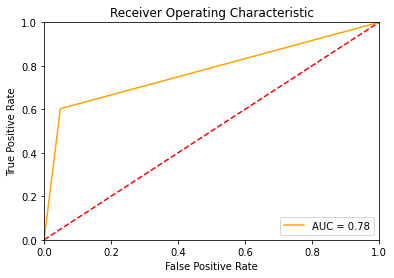

In [ ]:
#@title Run ROC analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

df_actual = pd.DataFrame([Y_test])
df_actual = df_actual.T

df_predicted = pd.DataFrame([output])
df_predicted = df_predicted.T

fpr, tpr, threshold = roc_curve(df_actual, df_predicted)
print(fpr, tpr, threshold)

auc_value = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f' % auc_value)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#@title Add words to the vocabulary (If there are missing words, you need to re-enter each time you restart)
#@markdown Please enter the text to be added to the vocabulary: (Enter one at a time)

word = "\u89AA\u5E2B\u751F" #@param {type: "string"}
jieba.add_word(word)